In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.6 MB/s eta 0:00:00


In [2]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 11.9 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket

import seaborn as sns

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [4]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [5]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [6]:
def get_duration(file):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [7]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [23:29,  2.47it/s]


In [8]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [9]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [10]:
appended = []
for i in range(1,4):
    appended.append(sorted_df[sorted_df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Grunt,Roar,IRoar
0,fold1,496,332,326
1,fold2,496,329,329
2,fold3,499,332,332


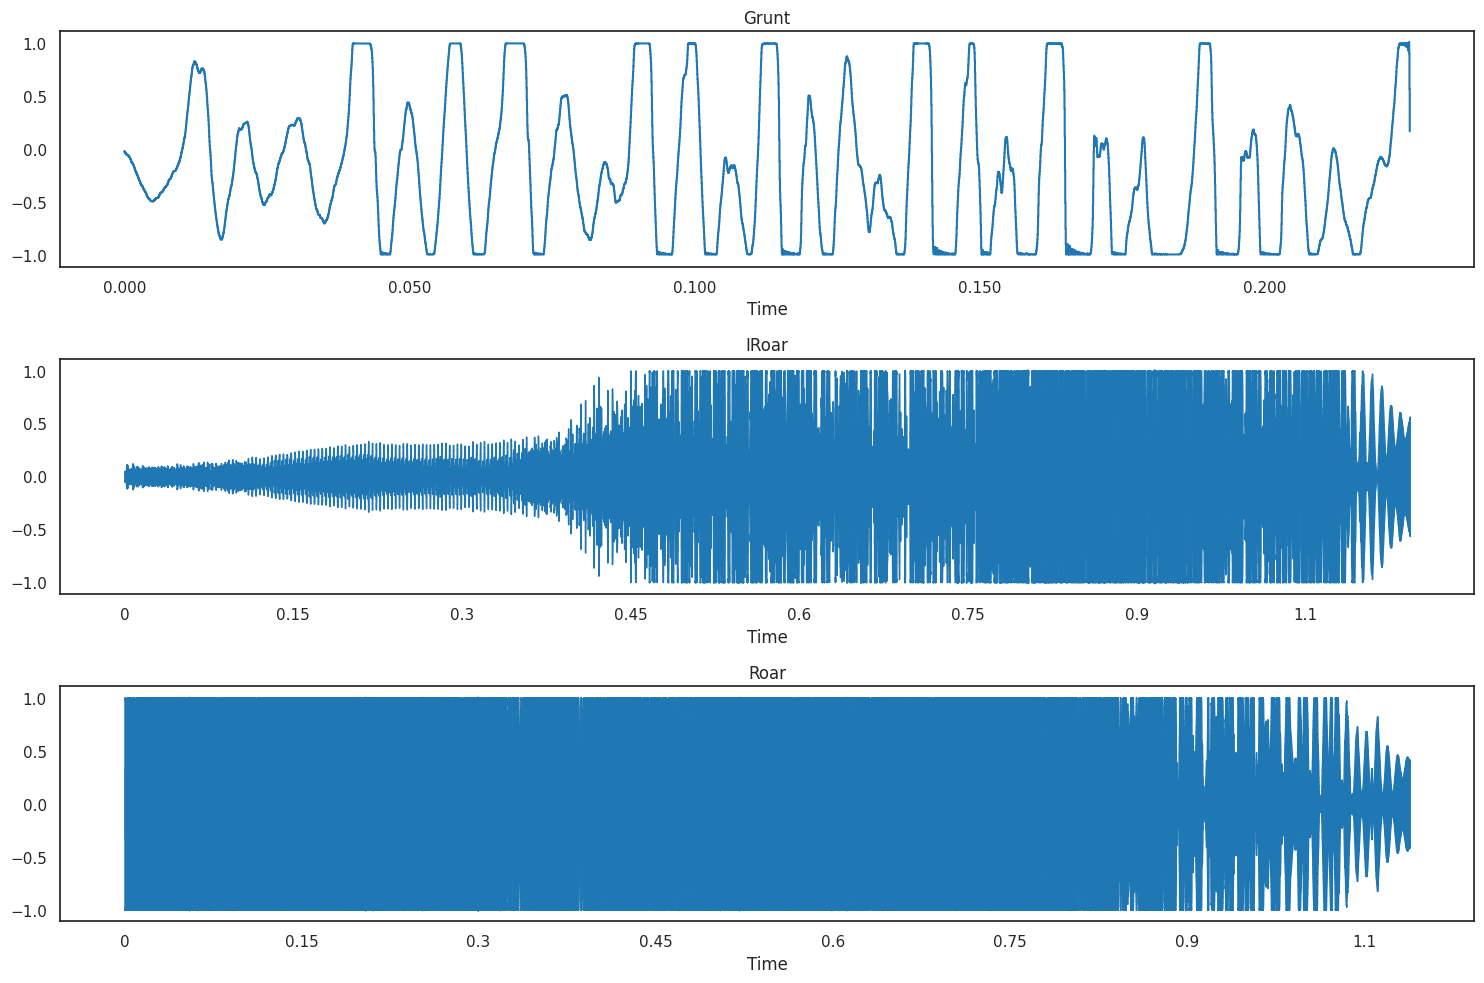

In [11]:
# Randomly select one sample of each class
random_samples = sorted_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

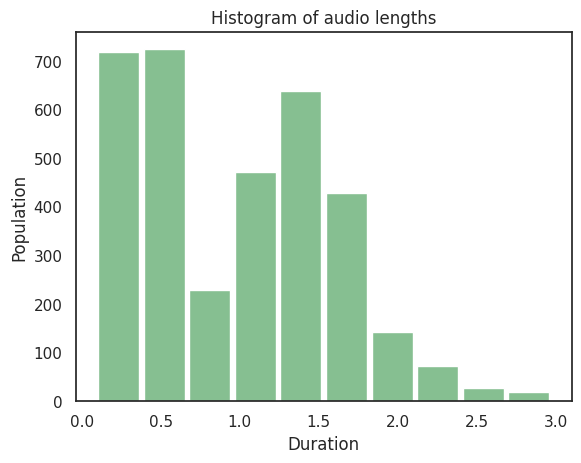

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 152
Lower than 2 but greater than 1 seconds: 1601
Lower than 1 seconds: 1718


In [12]:
plt.hist(sorted_df['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = sorted_df['duration'][(sorted_df['duration'] > 3)].count()
gt_2sec = sorted_df['duration'][(sorted_df['duration'] > 2) & (sorted_df['duration'] < 3)].count()
lt_2sec = sorted_df['duration'][(sorted_df['duration'] > 1) & (sorted_df['duration'] < 2)].count()
lt_1sec = sorted_df['duration'][sorted_df['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [14]:
# Feature extraction using librosa

x_train=[]
x_test=[]
y_train=[]
y_test=[]
start = 0
end = 0

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(sorted_df))):
    fold_no=str(sorted_df.iloc[i]["fold"])
    file=sorted_df.iloc[i]["slice_file_name"]
    label=sorted_df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)
    if sorted_df.iloc[i]["class"] == "IRoar":
      start = 40000
      end= 44000
    elif sorted_df.iloc[i]["class"] == "Roar":
      start = 7000
      end= 11000
    elif sorted_df.iloc[i]["class"] == "Grunt":
      start = 2000
      end= 6000
    mfccs = np.mean(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=40).T,axis=0)
    if(fold_no!='3'):
      x_train.append(mfccs)
      y_train.append(label)
    else:
      x_test.append(mfccs)
      y_test.append(label)

100%|██████████| 3471/3471 [02:39<00:00, 21.79it/s]


In [15]:
x=x_train+x_test
y=y_train+y_test

In [16]:
#saving the data numpy arrays
np.savetxt("x.csv", x, delimiter=",")
np.savetxt("y.csv",y,delimiter=",")

In [18]:
import math

indexes = []
total = len(sorted_df)
indexes = list(range(0, total))
# Randomize indexes random.shuffle(indexes)
# Divide the indexes into Train and Test
test_split_pct = 40
split_offset = math.floor(test_split_pct * total / 100)
# Split the data
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]
# Split the features with the same indexes
X_test = np.take(x, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(x, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)
# Also split metadata
test = df.iloc[test_split_idx]
train = df.iloc[train_split_idx]
# Print status
print("Test split: {} \t\t Train split: {}".format(len(test), len(train)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1388 		 Train split: 2083
X test shape: (1388, 40) 	 X train shape: (2083, 40)
y test shape: (1388,) 		 y train shape: (2083,)


In [19]:
#converting to one hot
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
y_train.shape,y_test.shape

((2083, 3), (1388, 3))

In [20]:
#reshaping to 3D
X_train=np.reshape(X_train,(X_train.shape[0], 1,40))
X_test=np.reshape(X_test,(X_test.shape[0], 1,40))
X_train.shape,X_test.shape

((2083, 1, 40), (1388, 1, 40))

In [21]:
y_train=np.reshape(y_train,(y_train.shape[0], 1,3))
y_test=np.reshape(y_test,(y_test.shape[0], 1,3))
y_train.shape,y_test.shape

((2083, 1, 3), (1388, 1, 3))

In [22]:
from keras.callbacks import History
history = History()

In [23]:
from keras.layers import LSTM,Input

# Model
model = Sequential()
model.add(LSTM(40,return_sequences=True,input_shape=(1,40)))
model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
model.add(Dense(512,activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation ='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 40)             12960     
                                                                 
 lstm_1 (LSTM)               (None, 1, 40)             12960     
                                                                 
 dense (Dense)               (None, 1, 512)            20992     
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 3)              1539      
                                                                 
Total params: 48,451
Trainable params: 48,451
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow import keras

In [25]:
#compiling
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#training the model
model.fit(X_train,y_train,batch_size=50,epochs=30,validation_data=(X_test,y_test), callbacks=[history])

Epoch 1/30
42/42 [==============================] - 9s 39ms/step - loss: 0.7726 - accuracy: 0.7614 - val_loss: 0.4957 - val_accuracy: 0.8523
Epoch 2/30
42/42 [==============================] - 0s 10ms/step - loss: 0.3611 - accuracy: 0.8853 - val_loss: 0.4162 - val_accuracy: 0.8588
Epoch 3/30
42/42 [==============================] - 0s 10ms/step - loss: 0.3183 - accuracy: 0.8973 - val_loss: 0.4106 - val_accuracy: 0.8573
Epoch 4/30
42/42 [==============================] - 0s 11ms/step - loss: 0.3070 - accuracy: 0.9001 - val_loss: 0.4063 - val_accuracy: 0.8588
Epoch 5/30
42/42 [==============================] - 0s 9ms/step - loss: 0.2929 - accuracy: 0.9059 - val_loss: 0.4068 - val_accuracy: 0.8595
Epoch 6/30
42/42 [==============================] - 1s 12ms/step - loss: 0.2797 - accuracy: 0.9112 - val_loss: 0.3894 - val_accuracy: 0.8674
Epoch 7/30
42/42 [==============================] - 0s 11ms/step - loss: 0.2704 - accuracy: 0.9169 - val_loss: 0.3915 - val_accuracy: 0.8624
Epoch 8/30
42/

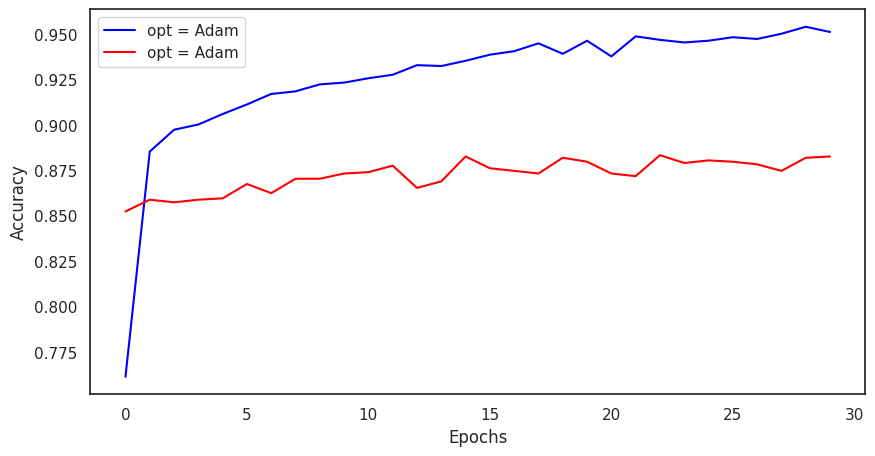

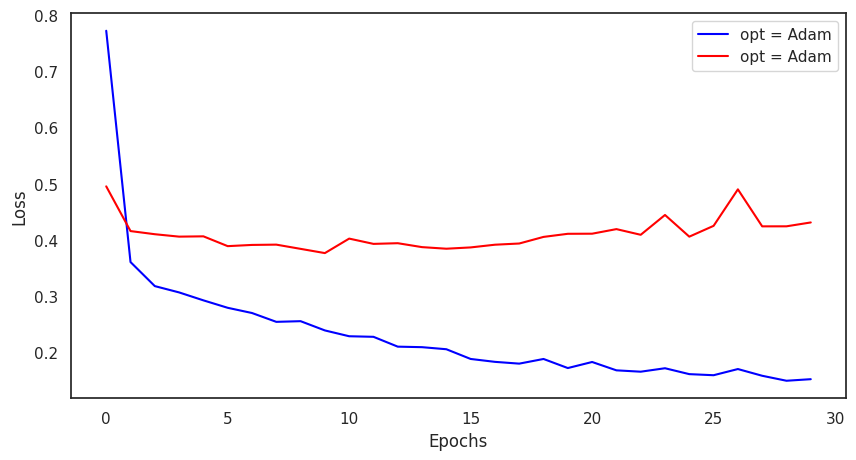

In [26]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],color='b', label="opt = Adam")
plt.plot(history.history['val_accuracy'],color='r', label="opt = Adam")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],color='b', label="opt = Adam")
plt.plot(history.history['val_loss'],color='r', label="opt = Adam")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

44/44 [==============================] - 0s 3ms/step - loss: 0.4315 - accuracy: 0.8826
[0.13304579257965088, 0.9563130140304565]
[0.4315367639064789, 0.8825648427009583]


In [28]:
# Predict probabilities for test set
y_probs = model.predict(X_test)
y_probs=np.reshape(y_probs,(y_probs.shape[0],3))
y_test=np.reshape(y_test,(y_test.shape[0] ,3))

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

# Add "pred" column
test['pred'] = yhat_probs

44/44 [==============================] - 3s 3ms/step


<ipython-input-28-165f4b6f795d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = yhat_probs


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
np.set_printoptions(precision=2)
# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)
print(cm)

[[327  15  51]
 [ 13 339  41]
 [ 21  22 559]]


In [32]:
# Define a labels array for future use
labels = [ 'Roar' , 'IRoar' , 'Grunt' ]
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2], target_names=labels)
print(re)

              precision    recall  f1-score   support

        Roar       0.91      0.83      0.87       393
       IRoar       0.90      0.86      0.88       393
       Grunt       0.86      0.93      0.89       602

    accuracy                           0.88      1388
   macro avg       0.89      0.87      0.88      1388
weighted avg       0.88      0.88      0.88      1388



In [33]:
# Set your path to the dataset
audio_path = os.path.abspath('/content/drive/MyDrive/ThesisData')

In [34]:
test.head()

,fs_id,slice_file_name,classID,fold,class,filepath,duration,pred
0,iroar_123,iroar_123.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...,1.785488,1
1,iroar_308,iroar_308.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...,1.264354,1
2,grunt_878,grunt_878.wav,2,2,Grunt,/content/drive/MyDrive/ThesisData/File2/grunt_...,0.303628,2
3,roar_178,roar_178.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_1...,1.393515,0
4,roar_963,roar_963.wav,0,3,Roar,/content/drive/MyDrive/ThesisData/File3/roar_9...,1.407211,2


In [35]:
# Find the target misclassified ocurrencies
grunt_as_roar = test[(test['classID'] == 2) & (test['pred'] == 0)]
files = []
for idx, row in grunt_as_roar.iterrows(): fold_num = str(row['fold'])
file_name = row['slice_file_name']
category = row['class']
file_path = audio_path + '/File'+ fold_num +'/' + file_name
files.append(file_path)
print("Lion Grunts as Lion Roars: {} ocurrencies".format(len(grunt_as_roar)))
# Manully set the file index
index = 24
# Display results
print("\nTrue category: {}".format(category))

Lion Grunts as Lion Roars: 157 ocurrencies

True category: Grunt
